In [4]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
# sys.path.append('../')
# import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
train_x_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
train_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
test_x_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
test_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")
train_x = torch.from_numpy(train_x_df.to_numpy())
train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
test_x = torch.from_numpy(test_x_df.to_numpy())
test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))


In [15]:
# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

train_y = train_y_df.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()


In [29]:
def rf_results(model, train_x, train_y, test_x, test_y): 
    """take in fitted model"""
    train_pred = model.predict(train_x) 
    test_pred = model.predict(test_x)
    train_acc = accuracy_score(train_y, train_pred) 
    test_acc = accuracy_score(test_y, test_pred) 
    print(f'train accuracy: {train_acc}')
    print(f'test accuracy: {test_acc}')
    train_prob = model.predict_proba(train_x) 
    test_prob = model.predict_proba(test_x) 
    return train_pred, test_pred, train_acc, test_acc, train_prob, test_prob

In [30]:
def rf_models(train_x, train_y, test_x, test_y, rf_type, parameters, dataset_type):
    n_estimators = parameters.get('n_estimators', 100)
    random_state = parameters.get('random_state', 42) 
    criterion = parameters.get('criterion', 'gini')
    max_depth = parameters.get('max_depth', 100)
    min_samples_split = parameters.get('min_samples_split', 2) 
    min_samples_leaf = parameters.get('min_samples_leaf', 1) 
    bootstrap = parameters.get('bootstrap', False) 
    max_features = parameters.get('max_features', None) 
    class_weight = parameters.get('class_weight', None)
    
    if (rf_type == 'balanced class_weight'): 
        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight='balanced')
    elif (rf_type == 'balanced RF'):
        model = BalancedRandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight=class_weight)
    else:
        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight=class_weight)
        
    model.fit(train_x, train_y)
    train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(model, train_x, train_y, test_x, test_y)
    classes = ['0','1']
    plot_confusion_matrix(train_y, train_pred, classes, title=f"NEK2 {dataset_type} Train: {rf_type}")
    plot_confusion_matrix(test_y, test_pred, classes, title=f"NEK2 {dataset_type} Test: {rf_type}")
    
    return {'model': model, 'train_pred':train_pred, 'test_pred': test_pred, 'train_prob':train_prob, 'test_prob': test_prob}

In [41]:
def find_best_models(train_x, train_y, test_x, test_y, rf_type, parameters, param_dist, dataset_type, save_filename, verbose_val=None):
    n_estimators = parameters.get('n_estimators', 100)
    random_state = parameters.get('random_state', 42) 
    criterion = parameters.get('criterion', 'gini')
    max_depth = parameters.get('max_depth', 100)
    min_samples_split = parameters.get('min_samples_split', 2) 
    min_samples_leaf = parameters.get('min_samples_leaf', 1) 
    bootstrap = parameters.get('bootstrap', False) 
    max_features = parameters.get('max_features', None) 
    class_weight = parameters.get('class_weight', None)
    bootstrap = parameters.get('bootstrap', False)
    if (verbose_val==None): 
        verbose_val = 0
    if (rf_type == 'balanced class_weight'): 
        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight='balanced')
    elif (rf_type == 'balanced RF'):
        model = BalancedRandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features)
    else:
        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight=class_weight)

    rand_search = RandomizedSearchCV(estimator =model, param_distributions = param_dist, cv=5, n_jobs=8, verbose=verbose_val)
    rand_search.fit(train_x, train_y) 
    best_rf = rand_search.best_estimator_
    best_params = best_rf.get_params()
    for param, value in best_params.items():
        print(f"{param}: {value}")
    train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(model, train_x, train_y, test_x, test_y)
    classes = ['0','1']
    plot_confusion_matrix(train_y, train_pred, classes, title=f"Best NEK2 {dataset_type} Train: {rf_type}")
    plot_confusion_matrix(test_y, test_pred, classes, title=f"Best NEK2 {dataset_type} Test: {rf_type}")
    pklfile = save_filename+'.pkl'
    with open(pklfile, 'wb') as f:
        pickle.dump(best_rf, f)
    return {'best_model': best_rf, 'train_pred':train_pred, 'test_pred': test_pred, 'train_prob':train_prob, 'test_prob': test_prob}
    

train accuracy: 1.0
test accuracy: 0.911660777385159


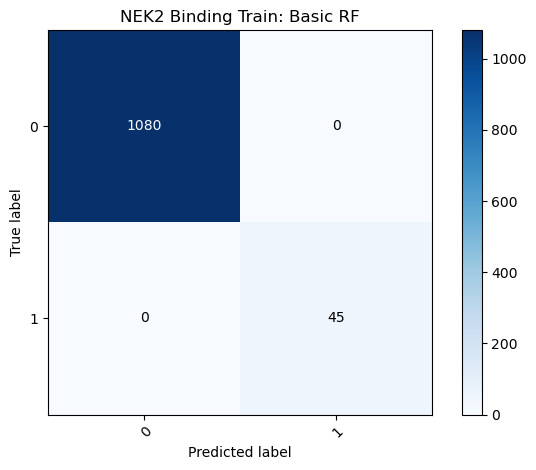

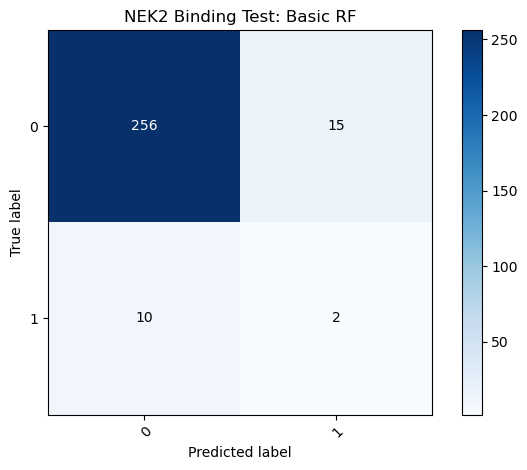

In [31]:
result1 = rf_models(train_x, train_y, test_x, test_y, 'Basic RF', {}, 'Binding')


In [ ]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 5, dtype = int),
    'max_depth': [20, 40, 60, 80, 100, 150, 200, 220],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4, 5],
    'criterion': ['gini','entropy']
}
result1_best = find_best_models(train_x, train_y, test_x, test_y, 'Basic RF', {}, 
                                param_grid, 'Binding', 'NEK2bind_gridsearch_basic_best', verbose_val=2)
# result1_best = find_best_models(train_x, train_y, test_x, test_y, 'Basic RF', {'bootstrap':True, 'class_weight':'balanced'}, 
#                                 param_grid, 'Binding', 'NEK2bind_gridsearch_basic_best', verbose_val=2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
result2 = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, 'Binding')


In [ ]:
result2_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {'bootstrap':True, 'class_weight':'balanced'}, 
                                param_grid, 'Binding', 'NEK2bind_gridsearch_classweightbal_best', verbose_val=2)

In [ ]:
result3 = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {}, 'Binding')

In [ ]:
result3_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {}, 
                                param_grid, 'Binding', 'NEK2bind_gridsearch_BRF_best', verbose_val=2)